In [5]:
# import all modules needed
import models.eda as eda

import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [6]:
# df_client and df_invoice are being loaded from the data folder
client = eda.load_data("data/train/client_train.csv")
invoice = eda.load_data("data/train/invoice_train.csv")
df = eda.feature_change(client, invoice)

/var/folders/zj/y95dm4bn0jz_s678nqhm92b80000gn/T/ipykernel_28482/1719099603.py:3: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  invoice = eda.load_data("data/train/invoice_train.csv")


In [7]:
df.head(5)

,district,client_id,client_catg,region,target,region_group,coop_time,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,months_number,counter_type,invoice_month,invoice_year,is_weekday,total_consumption
0,60,0,11,101,0.0,200,288,11,1335667,0,203,8,1,4,1,3,2014,0.0,82
1,60,0,11,101,0.0,200,288,11,1335667,0,203,6,1,4,1,3,2013,0.0,1384
2,60,0,11,101,0.0,200,288,11,1335667,0,203,8,1,4,1,3,2015,0.0,123
3,60,0,11,101,0.0,200,288,11,1335667,0,207,8,1,4,1,7,2015,0.0,102
4,60,0,11,101,0.0,200,288,11,1335667,0,207,9,1,12,1,11,2016,0.0,572


### Baseline model
- our very simple baseline model assumes every client from district 51 is fraudulent. 

In [8]:
def baseline_model(X):
    y_pred = [0 if cat != 51 else 1 for cat in X.client_catg]
    return y_pred

# in district 51 the most fraudulents appear:
pd.crosstab(df['target'], df['client_catg'], normalize='columns')*100

client_catg,11,12,51
target,,,
0.0,92.391486,94.413284,79.044952
1.0,7.608514,5.586716,20.955048


In [9]:
# Select the features to use for modeling
feature_cols = ['district','client_catg', 'region_group',
       'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'months_number', 'counter_type',
       'total_consumption', 'invoice_year']
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['target'], test_size=0.3, random_state=42)
y_pred = baseline_model(X_test)


In [10]:
print('F1-score:', precision_score(y_test, y_pred).round(2))
print('ROC AUC:', roc_auc_score(y_test, y_pred).round(2))

F1-score: 0.21
ROC AUC: 0.52


Figure(1000x600)


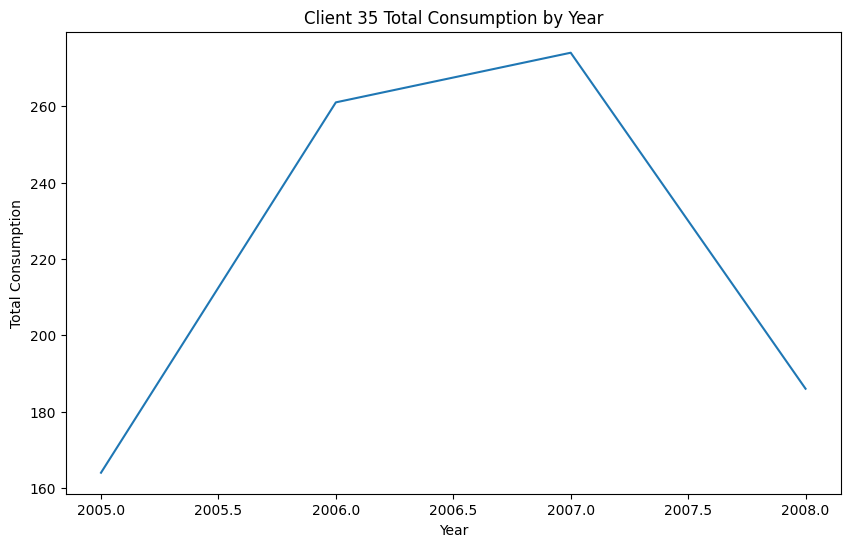

In [12]:
# fraudulent clients: [8, 13, 14, 21, 52, 67, 76, 87, 98, 114, 118, 153, 302, 306, 310, 356, 382, 388, 403]
import pandas as pd
import matplotlib.pyplot as plt

def plot_fraud(df, number):
    """This function plots a client's total consumption over the date of invoice.

    Args:
        df (DataFrame): the whole dataset having multiple clients and per client many invoices
        number (int): the client's number to be plotted

    Returns:
        plt: a plot with the total consumption over the date of invoice
    """
    # Select data for the specified client
    client = df.query(f"client_id == {number}")
    # Sort values according to date
    client = client.sort_values("invoice_year")
    # Group by year and sum total consumption for each year
    yearly_total = client.groupby(client["invoice_year"])["total_consumption"].sum()
    # Plot
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(yearly_total.index, yearly_total.values)
    ax.set_xlabel("Year")
    ax.set_ylabel("Total Consumption")
    ax.set_title(f"Client {number} Total Consumption by Year")
    return fig


print(plot_fraud(df, 35))



In [13]:
def get_mean_consumption(df):
    # Calculate the mean consumption per year for each client
    mean_consumption = df.groupby(["client_id", "invoice_year"])["total_consumption"].mean().reset_index()

    # Merge the mean consumption dataframe back into the original dfframe
    df = df.merge(mean_consumption, on=["client_id", "invoice_year"], how="left")
    df.rename(columns={"total_consumption_y": "mean_consumption_per_year", "total_consumption_x":"total_consumption"}, inplace=True)
    return df

# Define a function to calculate the historical mean consumption for each client
def historical_mean(group):
    # Sort the group by invoice year in ascending order
    group = group.sort_values('invoice_year')

    # Calculate the expanding mean for the total consumption column
    group['historical_mean_consumption'] = group['total_consumption'].expanding().mean()

    return group

def get_historical_mean(df):
    # Apply the function to the dataframe grouped by client id
    df = df.groupby('client_id').apply(historical_mean)
    df = df.reset_index(drop=True)
    # Shift the historical mean consumption column by one row to avoid using the current year's mean
    df['historical_mean_consumption'] = df.groupby('client_id')['historical_mean_consumption'].shift()
    df.historical_mean_consumption = df.historical_mean_consumption.fillna(0)

    # Check the updated dfframe
    return df

# df = get_mean_consumption(df)
# df = get_historical_mean(df)



## Load test dataset

In [23]:
client_test = eda.load_data("data/test/client_test.csv")
invoice_test = eda.load_data("data/test/invoice_test.csv")
test = eda.feature_change(client_test, invoice_test)
test = eda.get_mean_consumption(test)
#test = eda.get_historical_mean(test)

In [17]:
X_test = df.drop("target", axis=1)
y_test = df['target']

In [24]:
test.head()

,district,client_id,client_catg,region,region_group,coop_time,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,months_number,counter_type,invoice_month,invoice_year,is_weekday,total_consumption,mean_consumption_per_year
0,62,0,11,307,300,199,11,651208,0,203,8,1,8,1,3,2018,0.0,755,922.500000
1,62,0,11,307,300,199,11,651208,0,203,8,1,8,1,3,2014,0.0,1067,662.333333
2,62,0,11,307,300,199,11,651208,0,203,8,1,4,1,7,2014,0.0,0,662.333333
3,62,0,11,307,300,199,11,651208,0,203,9,1,4,1,7,2015,0.0,410,410.000000
4,62,0,11,307,300,199,11,651208,0,203,9,1,4,1,7,2016,0.0,412,620.000000
